<a href="https://colab.research.google.com/github/Ranjan00/Avinash-Ranjan/blob/master/Phenology_20_May.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Earth Engine API and geemap (if needed)
!pip install earthengine-api geemap

import ee
import geemap

# Authenticate Earth Engine
ee.Authenticate()

# Initialize EE after authentication
ee.Initialize()


EEException: ee.Initialize: no project found. Call with project= or see http://goo.gle/ee-auth.

In [ ]:
def create_yearly_stack(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    yearly_imgs = nirv_collection.filterDate(start, end)

    count = yearly_imgs.size().getInfo()  # get int count for Python loop

    img_list = yearly_imgs.toList(count)

    # Start with an empty masked image (all masked)
    yearly_stack = ee.Image(0).updateMask(0)

    for i in range(count):
        img = ee.Image(img_list.get(i))
        yearly_stack = yearly_stack.addBands(img)

    # Rename bands properly
    band_names = ['NIRv_day_{}'.format(i+1) for i in range(count)]

    # The first band of yearly_stack is empty mask, so remove it
    yearly_stack = yearly_stack.select(range(1, yearly_stack.bandNames().size().getInfo()), band_names)

    return yearly_stack.clip(aoi)


In [ ]:
def calculate_phenometrics(yearly_stack):
    """
    yearly_stack: ee.Image with bands = NIRv time series of that year (e.g. 46 bands)

    Returns an image with bands SOS, EOS, POS, LOS.
    """
    # Number of time steps
    n_bands = yearly_stack.bandNames().size()

    # Convert band names to numbers 1..n for time (day of year approx.)
    # Assuming 8-day intervals: day = band_index * 8
    time_days = ee.List.sequence(1, n_bands.getInfo()).map(lambda i: i * 8)

    # Stack band values into a list image
    # Create an array image from the bands
    array_img = yearly_stack.toArray()

    # 1. Find POS (peak of season): max NIRv value and band index of max
    max_val = array_img.arrayReduce(ee.Reducer.max(), [0]).arrayGet([0])
    max_idx = array_img.arrayArgmax(0).arrayGet([0])

    # 2. Set threshold to 0.3 * max_val to find SOS and EOS - a simple approach
    threshold = max_val.multiply(0.3)

    # 3. Get array of band values as a list
    values = yearly_stack.toArray().arrayProject([0]).arrayFlatten([yearly_stack.bandNames()])

    # 4. Find SOS (first date when NIRv > threshold before POS)
    def find_sos(e):
        i = e
        val = array_img.arrayGet([i])
        return val.gte(threshold)
    # But Earth Engine does not support loop easily, so:
    # Better to create a mask of bands > threshold and find first true band index before POS

    # Create mask where bands > threshold
    mask = yearly_stack.gt(threshold)

    # Mask bands after POS index by setting false (0)
    # For this, create an image with band index values and compare with POS index

    band_indices = ee.Image.constant(ee.List.sequence(0, n_bands.subtract(1)))
    band_indices = band_indices.rename(yearly_stack.bandNames())

    # Mask bands after POS index: keep only bands <= POS
    mask_before_pos = band_indices.lte(max_idx)
    sos_mask = mask.And(mask_before_pos)

    # Find first band where sos_mask is True
    sos_idx = sos_mask.arrayArgmax(0).arrayGet([0])

    # Convert band index to day of year (assuming 8-day intervals)
    sos = sos_idx.add(1).multiply(8)
    pos = max_idx.add(1).multiply(8)

    # 5. Find EOS (last date after POS where NIRv > threshold)
    mask_after_pos = band_indices.gte(max_idx)
    eos_mask = mask.And(mask_after_pos)

    # Reverse eos_mask bands order and find first True band index (which corresponds to last True from original order)
    reversed_mask = eos_mask.arraySlice(0, 0, n_bands).arrayFlip(0)
    eos_idx_rev = reversed_mask.arrayArgmax(0).arrayGet([0])
    eos_idx = n_bands.subtract(1).subtract(eos_idx_rev)
    eos = eos_idx.add(1).multiply(8)

    # Length of season
    los = eos.subtract(sos)

    # Combine bands into a single image
    phenometrics = ee.Image.cat([
        sos.rename('SOS'),
        eos.rename('EOS'),
        pos.rename('POS'),
        los.rename('LOS')
    ]).toInt16()

    return phenometrics


In [ ]:
# Load MODIS MOD09A1 Surface Reflectance 8-Day
modis = ee.ImageCollection('MODIS/061/MOD09A1').select(['sur_refl_b02', 'sur_refl_b01'])

# Calculate NIRv = NIR * NDVI = (NIR - RED) / (NIR + RED) * NIR
def calculate_nirv(img):
    red = img.select('sur_refl_b01').multiply(0.0001)
    nir = img.select('sur_refl_b02').multiply(0.0001)
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    nirv = ndvi.multiply(nir).rename('NIRv')
    return img.addBands(nirv).select('NIRv').copyProperties(img, ['system:time_start'])

nirvCollection = modis.map(calculate_nirv)


In [ ]:
# Define AOI
aoi = ee.FeatureCollection("projects/ee-akr/assets/India_Updated")

In [ ]:
def create_yearly_stack(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    filtered = nirvCollection.filterDate(start, end).sort('system:time_start')
    filtered = nirvCollection.filterDate(start, end).filterBounds(aoi).sort('system:time_start')
    img_list = filtered.toList(filtered.size())
    band_count = img_list.size().getInfo()

    if band_count == 0:
        print(f"No images found for year {year}")
        return None

    def select_image_band(i):
        img = ee.Image(img_list.get(i))
        return img.select('NIRv').rename(ee.String('NIRv_').cat(ee.Number(i).format('%02d')))
     def select_image_band(i):
    img = ee.Image(img_list.get(i))
    return img.select('NIRv').rename(ee.String('NIRv_').cat(ee.Number(i).format('%02d'))).clip(aoi)

    indices = list(range(band_count))
    image_bands = [select_image_band(i) for i in indices]

    return ee.Image.cat(image_bands)

SyntaxError: unmatched ')' (<ipython-input-65-56b804188950>, line 19)

In [ ]:
def calculate_phenometrics(image_stack):
    band_names = image_stack.bandNames()
    n_bands = band_names.size()  # ee.Number

    # Get time_days as client-side list
    time_days = ee.List.sequence(1, n_bands).map(lambda i: ee.Number(i).multiply(8))
    time_days_list = time_days.getInfo()

    # Create image constant from client-side list
    time_img = ee.Image.constant(time_days_list).toArray()

    array_img = image_stack.toArray()

    # Concatenate along axis=1
    stacked = ee.Image.cat([time_img, array_img]).toArray(1)

    # Sort along axis=0 by time (keys)
    sorted_stack = stacked.arraySort(0)

    # Extract sorted time and nirv bands
    time_sorted = sorted_stack.arraySlice(1, 0, 1).arrayProject([0]).arrayFlatten([band_names])
    nirv_sorted = sorted_stack.arraySlice(1, 1, 2).arrayProject([0]).arrayFlatten([band_names])

    # Calculate phenometrics
    max_nirv = nirv_sorted.reduce(ee.Reducer.max())
    pos = nirv_sorted.arrayArgmax().arrayProject([0]).arrayFlatten([['index']])
    sos = nirv_sorted.gt(0.2).arrayArgmax().arrayProject([0]).arrayFlatten([['index']])
    eos = nirv_sorted.multiply(-1).arrayArgmax().arrayProject([0]).arrayFlatten([['index']])
    los = eos.subtract(sos)

    return ee.Image.cat([
        max_nirv.rename('max_NIRv'),
        pos.rename('POS'),
        sos.rename('SOS'),
        eos.rename('EOS'),
        los.rename('LOS')
    ])


In [ ]:
years = list(range(2000, 2025))
phenology_images = []

for year in years:
    print(f"Processing year: {year}")
    yearly_stack = create_yearly_stack(year)

    if yearly_stack is None:
        continue

    phenometrics_img = calculate_phenometrics(yearly_stack)
    phenology_images.append(phenometrics_img.set('year', year))

Processing year: 2000
Processing year: 2001
Processing year: 2002
Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023
Processing year: 2024


In [ ]:
missing_years = []
for year in years:
    if create_yearly_stack(year) is None:
        missing_years.append(year)

print("Years with missing data:", missing_years)


Years with missing data: []


In [ ]:
img_2020 = phenology_images[20]


In [ ]:
print("Number of bands:", n_bands.getInfo())
print("Time days list:", time_days_list)


NameError: name 'n_bands' is not defined

In [ ]:
# Visualize SOS for 2020 clipped to India
img_2020_clipped = img_2020.clip(aoi)

Map = geemap.Map()
Map.centerObject(aoi, 6)
Map.addLayer(img_2020_clipped.select('SOS'), {
    'min': 0, 'max': 365,
    'palette': ['blue', 'green', 'yellow', 'red']
}, 'SOS 2020')

Map.addLayer(aoi, {}, 'AOI')
Map


EEException: Image.arraySort: Image and keys must have same dimensions, found 2 and 0.

In [ ]:
# Create export tasks for each year and band
for i, year in enumerate(range(2000, 2025)):
    if i >= len(phenology_images):
        print(f"Skipping year {year} (no image)")
        continue

    image = phenology_images[i].clip(aoi)

    # Loop over each phenology band
    for band in ['SOS', 'EOS', 'POS', 'LOS', 'max_NIRv']:
        export_name = f"{band}_{year}"
        task = ee.batch.Export.image.toDrive(
            image=image.select(band),
            description=export_name,
            folder='GEE_Exports',  # Or change this to your Drive folder
            fileNamePrefix=export_name,
            region=aoi.geometry(),
            scale=500,  # MODIS native scale
            maxPixels=1e13
        )
        task.start()
        print(f"Started export task: {export_name}")


EEException: Request had insufficient authentication scopes.

In [ ]:
#Good code..it worked....8 day

import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Load India AOI
aoi = ee.FeatureCollection("projects/ee-akr/assets/India_Updated")

# Load MODIS MOD09A1 Surface Reflectance 8-Day (500m)
modis = ee.ImageCollection('MODIS/061/MOD09Q1') \
    .filterBounds(aoi)  # filter by India AOI

# Function to calculate NIRv = NDVI * NIR
def calculate_nirv(img):
    red = img.select('sur_refl_b01').multiply(0.0001)
    nir = img.select('sur_refl_b02').multiply(0.0001)
    nirv = nir.subtract(red).divide(nir.add(red)).rename('NIRv')
    #nirv = (ndvi.subtract(0.08)).multiply(nir).rename('NIRv')
    return img.addBands(nirv).select('NIRv').copyProperties(img, ['system:time_start'])

# Map NIRv calculation over MODIS collection
nirv_collection = modis.map(calculate_nirv)

# Visualize NIRv for a sample date (e.g., 2020-04-01)
sample_date = ee.Date('2020-04-01')
sample_img = nirv_collection.filterDate(sample_date, sample_date.advance(8, 'day')).first().clip(aoi)

# Visualization parameters for NIRv
nirv_vis = {
    'min': 0,
    'max': 0.5,
    'palette': ['white', 'blue', 'green', 'yellow', 'red']
}

# Create a map and add layer
Map = geemap.Map(center=[22.5, 80], zoom=5)
Map.addLayer(sample_img, nirv_vis, 'NIRv 2020-04-01')
Map.addLayer(aoi.style(color='red', fillColor=None, width=2), {}, 'India AOI')
Map

# Function to create an 8-day NIRv stack for a given year
def create_8day_nirv_stack(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    filtered = nirv_collection.filterDate(start, end).sort('system:time_start').filterBounds(aoi)
    count = filtered.size().getInfo()
    if count == 0:
        print(f"No images found for year {year}")
        return None

    img_list = filtered.toList(count)

    def select_band(i):
        img = ee.Image(img_list.get(i))
        return img.rename(ee.String('NIRv_').cat(ee.Number(i).format('%03d'))).clip(aoi)

    bands = [select_band(i) for i in range(count)]
    return ee.Image.cat(bands).clip(aoi)

# Example: create 8-day NIRv stack for 2020
year = 2020
nirv_stack_2020 = create_8day_nirv_stack(year)
print(nirv_stack_2020.bandNames().getInfo())


['NIRv_000', 'NIRv_001', 'NIRv_002', 'NIRv_003', 'NIRv_004', 'NIRv_005', 'NIRv_006', 'NIRv_007', 'NIRv_008', 'NIRv_009', 'NIRv_010', 'NIRv_011', 'NIRv_012', 'NIRv_013', 'NIRv_014', 'NIRv_015', 'NIRv_016', 'NIRv_017', 'NIRv_018', 'NIRv_019', 'NIRv_020', 'NIRv_021', 'NIRv_022', 'NIRv_023', 'NIRv_024', 'NIRv_025', 'NIRv_026', 'NIRv_027', 'NIRv_028', 'NIRv_029', 'NIRv_030', 'NIRv_031', 'NIRv_032', 'NIRv_033', 'NIRv_034', 'NIRv_035', 'NIRv_036', 'NIRv_037', 'NIRv_038', 'NIRv_039', 'NIRv_040', 'NIRv_041', 'NIRv_042', 'NIRv_043', 'NIRv_044', 'NIRv_045']


In [ ]:
# Visualize the first band 'NIRv_000' of the yearly stack
nirv_first_band = nirv_stack_2020.select('NIRv_000')

# Define visualization parameters for NIRv (adjust min/max as needed)
nirv_vis_params = {
    'min': 0.0,
    'max': 0.5,
    'palette': ['white', 'blue', 'green', 'yellow', 'red']
}

# Add the single band layer to the map
Map.addLayer(nirv_first_band, nirv_vis_params, 'NIRv First Band (NIRv_000)')
Map.centerObject(aoi, 5)
Map


Map(center=[23.228268671636336, 79.45876757981225], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
import ee
import geemap

ee.Authenticate()
ee.Initialize()

# Load India AOI
aoi = ee.FeatureCollection("projects/ee-akr/assets/India_Updated")

# Load MODIS MCD43A4 daily collection
modis_daily = ee.ImageCollection("MODIS/061/MCD43A4").filterBounds(aoi)


def create_5day_median_composites(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')

    # Filter collection for the year and AOI
    collection = modis_daily.filterDate(start_date, end_date).filterBounds(aoi)

    # Generate 5-day intervals throughout the year
    n_intervals = int(365 / 5) + 1
    intervals = [start_date.advance(5 * i, 'day') for i in range(n_intervals)]

    # Create list of median composites for each 5-day interval
    composites = []
    for i in range(len(intervals) - 1):
        interval_start = intervals[i]
        interval_end = intervals[i+1]
        composite = collection.filterDate(interval_start, interval_end).median() \
            .set('system:time_start', interval_start.millis()) \
            .clip(aoi)
        composites.append(composite)

    return ee.ImageCollection(composites)


year = 2020
composites_5day = create_5day_median_composites(year)

# Print number of composites created
print("Number of 5-day composites:", composites_5day.size().getInfo())

# Visualize the first 5-day composite
first_composite = composites_5day.first()

# Visualization parameters for Band 1 (Red: Nadir_Reflectance_Band1)
vis_params = {
    'min': 0,
    'max': 0.3,
    'palette': ['black', 'blue', 'green', 'yellow', 'red']
}

Map = geemap.Map(center=[22.5, 80], zoom=5)
Map.addLayer(first_composite.select('Nadir_Reflectance_Band1'), vis_params, '5-day Median Composite Band 1')
Map.addLayer(aoi.style(color='red', fillColor=None, width=2), {}, 'India AOI')
Map



Number of 5-day composites: 73


Map(center=[22.5, 80], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [ ]:
import ee
import geemap

ee.Authenticate()
ee.Initialize()

aoi = ee.FeatureCollection("projects/ee-akr/assets/India_Updated")
modis_daily = ee.ImageCollection("MODIS/061/MCD43A4").filterBounds(aoi)

def create_5day_median_stack(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')
    collection = modis_daily.filterDate(start_date, end_date).filterBounds(aoi)
    n_intervals = ee.Number(end_date.difference(start_date, 'day')).divide(5).ceil().toInt()
    interval_indices = ee.List.sequence(0, n_intervals.subtract(1))

    def composite_for_interval(idx):
        idx = ee.Number(idx)
        interval_start = start_date.advance(idx.multiply(5), 'day')
        interval_end = interval_start.advance(5, 'day')
        imgs = collection.filterDate(interval_start, interval_end)
        median_img = imgs.median().clip(aoi)
        old_names = median_img.bandNames()
        # Use the index (idx) for band suffix, not the date!
        new_names = old_names.map(lambda b: ee.String(b).cat('_').cat(idx.format('%03d')))
        return median_img.rename(new_names)

    composites_list = interval_indices.map(composite_for_interval)
    composites_ic = ee.ImageCollection(composites_list)
    stacked = composites_ic.toBands().clip(aoi)
    return stacked

# Usage
year = 2020
median_5day_stack = create_5day_median_stack(year)
print(median_5day_stack.bandNames().getInfo())

Map = geemap.Map(center=[22.5, 80], zoom=5)
vis_params = {'min': 0, 'max': 0.3, 'palette': ['black', 'blue', 'green', 'yellow', 'red']}
Map.addLayer(median_5day_stack.select('Nadir_Reflectance_Band1_000'), vis_params, '5-day Median Composite Band 1 (first interval)')
Map.addLayer(aoi.style(color='red', fillColor=None, width=2), {}, 'India AOI')
Map


['0_Nadir_Reflectance_Band1_000', '0_Nadir_Reflectance_Band2_000', '0_Nadir_Reflectance_Band3_000', '0_Nadir_Reflectance_Band4_000', '0_Nadir_Reflectance_Band5_000', '0_Nadir_Reflectance_Band6_000', '0_Nadir_Reflectance_Band7_000', '0_BRDF_Albedo_Band_Mandatory_Quality_Band1_000', '0_BRDF_Albedo_Band_Mandatory_Quality_Band2_000', '0_BRDF_Albedo_Band_Mandatory_Quality_Band3_000', '0_BRDF_Albedo_Band_Mandatory_Quality_Band4_000', '0_BRDF_Albedo_Band_Mandatory_Quality_Band5_000', '0_BRDF_Albedo_Band_Mandatory_Quality_Band6_000', '0_BRDF_Albedo_Band_Mandatory_Quality_Band7_000', '1_Nadir_Reflectance_Band1_001', '1_Nadir_Reflectance_Band2_001', '1_Nadir_Reflectance_Band3_001', '1_Nadir_Reflectance_Band4_001', '1_Nadir_Reflectance_Band5_001', '1_Nadir_Reflectance_Band6_001', '1_Nadir_Reflectance_Band7_001', '1_BRDF_Albedo_Band_Mandatory_Quality_Band1_001', '1_BRDF_Albedo_Band_Mandatory_Quality_Band2_001', '1_BRDF_Albedo_Band_Mandatory_Quality_Band3_001', '1_BRDF_Albedo_Band_Mandatory_Quality

EEException: Image.select: Band pattern 'Nadir_Reflectance_Band1_000' did not match any bands. Available bands: [0_Nadir_Reflectance_Band1_000, 0_Nadir_Reflectance_Band2_000, 0_Nadir_Reflectance_Band3_000, 0_Nadir_Reflectance_Band4_000, 0_Nadir_Reflectance_Band5_000, 0_Nadir_Reflectance_Band6_000, 0_Nadir_Reflectance_Band7_000, 0_BRDF_Albedo_Band_Mandatory_Quality_Band1_000, 0_BRDF_Albedo_Band_Mandatory_Quality_Band2_000, 0_BRDF_Albedo_Band_Mandatory_Quality_Band3_000, 0_BRDF_Albedo_Band_Mandatory_Quality_Band4_000, 0_BRDF_Albedo_Band_Mandatory_Quality_Band5_000, 0_BRDF_Albedo_Band_Mandatory_Quality_Band6_000, 0_BRDF_Albedo_Band_Mandatory_Quality_Band7_000, 1_Nadir_Reflectance_Band1_001, 1_Nadir_Reflectance_Band2_001, 1_Nadir_Reflectance_Band3_001, 1_Nadir_Reflectance_Band4_001, 1_Nadir_Reflectance_Band5_001, 1_Nadir_Reflectance_Band6_001, 1_Nadir_Reflectance_Band7_001, 1_BRDF_Albedo_Band_Mandatory_Quality_Band1_001, 1_BRDF_Albedo_Band_Mandatory_Quality_Band2_001, 1_BRDF_Albedo_Band_Mandatory_Quality_Band3_001, 1_BRDF_Albedo_Band_Mandatory_Quality_Band4_001, 1_BRDF_Albedo_Band_Mandatory_Quality_Band5_001, 1_BRDF_Albedo_Band_Mandatory_Quality_Band6_001, 1_BRDF_Albedo_Band_Mandatory_Quality_Band7_001, 2_Nadir_Reflectance_Band1_002, 2_Nadir_Reflectance_Band2_002, 2_Nadir_Reflectance_Band3_002, 2_Nadir_Reflectance_Band4_002, 2_Nadir_Reflectance_Band5_002, 2_Nadir_Reflectance_Band6_002, 2_Nadir_Reflectance_Band7_002, 2_BRDF_Albedo_Band_Mandatory_Quality_Band1_002, 2_BRDF_Albedo_Band_Mandatory_Quality_Band2_002, 2_BRDF_Albedo_Band_Mandatory_Quality_Band3_002, 2_BRDF_Albedo_Band_Mandatory_Quality_Band4_002, 2_BRDF_Albedo_Band_Mandatory_Quality_Band5_002, 2_BRDF_Albedo_Band_Mandatory_Quality_Band6_002, 2_BRDF_Albedo_Band_Mandatory_Quality_Band7_002, 3_Nadir_Reflectance_Band1_003, 3_Nadir_Reflectance_Band2_003, 3_Nadir_Reflectance_Band3_003, 3_Nadir_Reflectance_Band4_003, 3_Nadir_Reflectance_Band5_003, 3_Nadir_Reflectance_Band6_003, 3_Nadir_Reflectance_Band7_003, 3_BRDF_Albedo_Band_Mandatory_Quality_Band1_003, 3_BRDF_Albedo_Band_Mandatory_Quality_Band2_003, 3_BRDF_Albedo_Band_Mandatory_Quality_Band3_003, 3_BRDF_Albedo_Band_Mandatory_Quality_Band4_003, 3_BRDF_Albedo_Band_Mandatory_Quality_Band5_003, 3_BRDF_Albedo_Band_Mandatory_Quality_Band6_003, 3_BRDF_Albedo_Band_Mandatory_Quality_Band7_003, 4_Nadir_Reflectance_Band1_004, 4_Nadir_Reflectance_Band2_004, 4_Nadir_Reflectance_Band3_004, 4_Nadir_Reflectance_Band4_004, 4_Nadir_Reflectance_Band5_004, 4_Nadir_Reflectance_Band6_004, 4_Nadir_Reflectance_Band7_004, 4_BRDF_Albedo_Band_Mandatory_Quality_Band1_004, 4_BRDF_Albedo_Band_Mandatory_Quality_Band2_004, 4_BRDF_Albedo_Band_Mandatory_Quality_Band3_004, 4_BRDF_Albedo_Band_Mandatory_Quality_Band4_004, 4_BRDF_Albedo_Band_Mandatory_Quality_Band5_004, 4_BRDF_Albedo_Band_Mandatory_Quality_Band6_004, 4_BRDF_Albedo_Band_Mandatory_Quality_Band7_004, 5_Nadir_Reflectance_Band1_005, 5_Nadir_Reflectance_Band2_005, 5_Nadir_Reflectance_Band3_005, 5_Nadir_Reflectance_Band4_005, 5_Nadir_Reflectance_Band5_005, 5_Nadir_Reflectance_Band6_005, 5_Nadir_Reflectance_Band7_005, 5_BRDF_Albedo_Band_Mandatory_Quality_Band1_005, 5_BRDF_Albedo_Band_Mandatory_Quality_Band2_005, 5_BRDF_Albedo_Band_Mandatory_Quality_Band3_005, 5_BRDF_Albedo_Band_Mandatory_Quality_Band4_005, 5_BRDF_Albedo_Band_Mandatory_Quality_Band5_005, 5_BRDF_Albedo_Band_Mandatory_Quality_Band6_005, 5_BRDF_Albedo_Band_Mandatory_Quality_Band7_005, 6_Nadir_Reflectance_Band1_006, 6_Nadir_Reflectance_Band2_006, 6_Nadir_Reflectance_Band3_006, 6_Nadir_Reflectance_Band4_006, 6_Nadir_Reflectance_Band5_006, 6_Nadir_Reflectance_Band6_006, 6_Nadir_Reflectance_Band7_006, 6_BRDF_Albedo_Band_Mandatory_Quality_Band1_006, 6_BRDF_Albedo_Band_Mandatory_Quality_Band2_006, 6_BRDF_Albedo_Band_Mandatory_Quality_Band3_006, 6_BRDF_Albedo_Band_Mandatory_Quality_Band4_006, 6_BRDF_Albedo_Band_Mandatory_Quality_Band5_006, 6_BRDF_Albedo_Band_Mandatory_Quality_Band6_006, 6_BRDF_Albedo_Band_Mandatory_Quality_Band7_006, 7_Nadir_Reflectance_Band1_007, 7_Nadir_Reflectance_Band2_007, 7_Nadir_Reflectance_Band3_007, 7_Nadir_Reflectance_Band4_007, 7_Nadir_Reflectance_Band5_007, 7_Nadir_Reflectance_Band6_007, 7_Nadir_Reflectance_Band7_007, 7_BRDF_Albedo_Band_Mandatory_Quality_Band1_007, 7_BRDF_Albedo_Band_Mandatory_Quality_Band2_007, 7_BRDF_Albedo_Band_Mandatory_Quality_Band3_007, 7_BRDF_Albedo_Band_Mandatory_Quality_Band4_007, 7_BRDF_Albedo_Band_Mandatory_Quality_Band5_007, 7_BRDF_Albedo_Band_Mandatory_Quality_Band6_007, 7_BRDF_Albedo_Band_Mandatory_Quality_Band7_007, 8_Nadir_Reflectance_Band1_008, 8_Nadir_Reflectance_Band2_008, 8_Nadir_Reflectance_Band3_008, 8_Nadir_Reflectance_Band4_008, 8_Nadir_Reflectance_Band5_008, 8_Nadir_Reflectance_Band6_008, 8_Nadir_Reflectance_Band7_008, 8_BRDF_Albedo_Band_Mandatory_Quality_Band1_008, 8_BRDF_Albedo_Band_Mandatory_Quality_Band2_008, 8_BRDF_Albedo_Band_Mandatory_Quality_Band3_008, 8_BRDF_Albedo_Band_Mandatory_Quality_Band4_008, 8_BRDF_Albedo_Band_Mandatory_Quality_Band5_008, 8_BRDF_Albedo_Band_Mandatory_Quality_Band6_008, 8_BRDF_Albedo_Band_Mandatory_Quality_Band7_008, 9_Nadir_Reflectance_Band1_009, 9_Nadir_Reflectance_Band2_009, 9_Nadir_Reflectance_Band3_009, 9_Nadir_Reflectance_Band4_009, 9_Nadir_Reflectance_Band5_009, 9_Nadir_Reflectance_Band6_009, 9_Nadir_Reflectance_Band7_009, 9_BRDF_Albedo_Band_Mandatory_Quality_Band1_009, 9_BRDF_Albedo_Band_Mandatory_Quality_Band2_009, 9_BRDF_Albedo_Band_Mandatory_Quality_Band3_009, 9_BRDF_Albedo_Band_Mandatory_Quality_Band4_009, 9_BRDF_Albedo_Band_Mandatory_Quality_Band5_009, 9_BRDF_Albedo_Band_Mandatory_Quality_Band6_009, 9_BRDF_Albedo_Band_Mandatory_Quality_Band7_009, 10_Nadir_Reflectance_Band1_010, 10_Nadir_Reflectance_Band2_010, 10_Nadir_Reflectance_Band3_010, 10_Nadir_Reflectance_Band4_010, 10_Nadir_Reflectance_Band5_010, 10_Nadir_Reflectance_Band6_010, 10_Nadir_Reflectance_Band7_010, 10_BRDF_Albedo_Band_Mandatory_Quality_Band1_010, 10_BRDF_Albedo_Band_Mandatory_Quality_Band2_010, 10_BRDF_Albedo_Band_Mandatory_Quality_Band3_010, 10_BRDF_Albedo_Band_Mandatory_Quality_Band4_010, 10_BRDF_Albedo_Band_Mandatory_Quality_Band5_010, 10_BRDF_Albedo_Band_Mandatory_Quality_Band6_010, 10_BRDF_Albedo_Band_Mandatory_Quality_Band7_010, 11_Nadir_Reflectance_Band1_011, 11_Nadir_Reflectance_Band2_011, 11_Nadir_Reflectance_Band3_011, 11_Nadir_Reflectance_Band4_011, 11_Nadir_Reflectance_Band5_011, 11_Nadir_Reflectance_Band6_011, 11_Nadir_Reflectance_Band7_011, 11_BRDF_Albedo_Band_Mandatory_Quality_Band1_011, 11_BRDF_Albedo_Band_Mandatory_Quality_Band2_011, 11_BRDF_Albedo_Band_Mandatory_Quality_Band3_011, 11_BRDF_Albedo_Band_Mandatory_Quality_Band4_011, 11_BRDF_Albedo_Band_Mandatory_Quality_Band5_011, 11_BRDF_Albedo_Band_Mandatory_Quality_Band6_011, 11_BRDF_Albedo_Band_Mandatory_Quality_Band7_011, 12_Nadir_Reflectance_Band1_012, 12_Nadir_Reflectance_Band2_012, 12_Nadir_Reflectance_Band3_012, 12_Nadir_Reflectance_Band4_012, 12_Nadir_Reflectance_Band5_012, 12_Nadir_Reflectance_Band6_012, 12_Nadir_Reflectance_Band7_012, 12_BRDF_Albedo_Band_Mandatory_Quality_Band1_012, 12_BRDF_Albedo_Band_Mandatory_Quality_Band2_012, 12_BRDF_Albedo_Band_Mandatory_Quality_Band3_012, 12_BRDF_Albedo_Band_Mandatory_Quality_Band4_012, 12_BRDF_Albedo_Band_Mandatory_Quality_Band5_012, 12_BRDF_Albedo_Band_Mandatory_Quality_Band6_012, 12_BRDF_Albedo_Band_Mandatory_Quality_Band7_012, 13_Nadir_Reflectance_Band1_013, 13_Nadir_Reflectance_Band2_013, 13_Nadir_Reflectance_Band3_013, 13_Nadir_Reflectance_Band4_013, 13_Nadir_Reflectance_Band5_013, 13_Nadir_Reflectance_Band6_013, 13_Nadir_Reflectance_Band7_013, 13_BRDF_Albedo_Band_Mandatory_Quality_Band1_013, 13_BRDF_Albedo_Band_Mandatory_Quality_Band2_013, 13_BRDF_Albedo_Band_Mandatory_Quality_Band3_013, 13_BRDF_Albedo_Band_Mandatory_Quality_Band4_013, 13_BRDF_Albedo_Band_Mandatory_Quality_Band5_013, 13_BRDF_Albedo_Band_Mandatory_Quality_Band6_013, 13_BRDF_Albedo_Band_Mandatory_Quality_Band7_013, 14_Nadir_Reflectance_Band1_014, 14_Nadir_Reflectance_Band2_014, 14_Nadir_Reflectance_Band3_014, 14_Nadir_Reflectance_Band4_014, 14_Nadir_Reflectance_Band5_014, 14_Nadir_Reflectance_Band6_014, 14_Nadir_Reflectance_Band7_014, 14_BRDF_Albedo_Band_Mandatory_Quality_Band1_014, 14_BRDF_Albedo_Band_Mandatory_Quality_Band2_014, 14_BRDF_Albedo_Band_Mandatory_Quality_Band3_014, 14_BRDF_Albedo_Band_Mandatory_Quality_Band4_014, 14_BRDF_Albedo_Band_Mandatory_Quality_Band5_014, 14_BRDF_Albedo_Band_Mandatory_Quality_Band6_014, 14_BRDF_Albedo_Band_Mandatory_Quality_Band7_014, 15_Nadir_Reflectance_Band1_015, 15_Nadir_Reflectance_Band2_015, 15_Nadir_Reflectance_Band3_015, 15_Nadir_Reflectance_Band4_015, 15_Nadir_Reflectance_Band5_015, 15_Nadir_Reflectance_Band6_015, 15_Nadir_Reflectance_Band7_015, 15_BRDF_Albedo_Band_Mandatory_Quality_Band1_015, 15_BRDF_Albedo_Band_Mandatory_Quality_Band2_015, 15_BRDF_Albedo_Band_Mandatory_Quality_Band3_015, 15_BRDF_Albedo_Band_Mandatory_Quality_Band4_015, 15_BRDF_Albedo_Band_Mandatory_Quality_Band5_015, 15_BRDF_Albedo_Band_Mandatory_Quality_Band6_015, 15_BRDF_Albedo_Band_Mandatory_Quality_Band7_015, 16_Nadir_Reflectance_Band1_016, 16_Nadir_Reflectance_Band2_016, 16_Nadir_Reflectance_Band3_016, 16_Nadir_Reflectance_Band4_016, 16_Nadir_Reflectance_Band5_016, 16_Nadir_Reflectance_Band6_016, 16_Nadir_Reflectance_Band7_016, 16_BRDF_Albedo_Band_Mandatory_Quality_Band1_016, 16_BRDF_Albedo_Band_Mandatory_Quality_Band2_016, 16_BRDF_Albedo_Band_Mandatory_Quality_Band3_016, 16_BRDF_Albedo_Band_Mandatory_Quality_Band4_016, 16_BRDF_Albedo_Band_Mandatory_Quality_Band5_016, 16_BRDF_Albedo_Band_Mandatory_Quality_Band6_016, 16_BRDF_Albedo_Band_Mandatory_Quality_Band7_016, 17_Nadir_Reflectance_Band1_017, 17_Nadir_Reflectance_Band2_017, 17_Nadir_Reflectance_Band3_017, 17_Nadir_Reflectance_Band4_017, 17_Nadir_Reflectance_Band5_017, 17_Nadir_Reflectance_Band6_017, 17_Nadir_Reflectance_Band7_017, 17_BRDF_Albedo_Band_Mandatory_Quality_Band1_017, 17_BRDF_Albedo_Band_Mandatory_Quality_Band2_017, 17_BRDF_Albedo_Band_Mandatory_Quality_Band3_017, 17_BRDF_Albedo_Band_Mandatory_Quality_Band4_017, 17_BRDF_Albedo_Band_Mandatory_Quality_Band5_017, 17_BRDF_Albedo_Band_Mandatory_Quality_Band6_017, 17_BRDF_Albedo_Band_Mandatory_Quality_Band7_017, 18_Nadir_Reflectance_Band1_018, 18_Nadir_Reflectance_Band2_018, 18_Nadir_Reflectance_Band3_018, 18_Nadir_Reflectance_Band4_018, 18_Nadir_Reflectance_Band5_018, 18_Nadir_Reflectance_Band6_018, 18_Nadir_Reflectance_Band7_018, 18_BRDF_Albedo_Band_Mandatory_Quality_Band1_018, 18_BRDF_Albedo_Band_Mandatory_Quality_Band2_018, 18_BRDF_Albedo_Band_Mandatory_Quality_Band3_018, 18_BRDF_Albedo_Band_Mandatory_Quality_Band4_018, 18_BRDF_Albedo_Band_Mandatory_Quality_Band5_018, 18_BRDF_Albedo_Band_Mandatory_Quality_Band6_018, 18_BRDF_Albedo_Band_Mandatory_Quality_Band7_018, 19_Nadir_Reflectance_Band1_019, 19_Nadir_Reflectance_Band2_019, 19_Nadir_Reflectance_Band3_019, 19_Nadir_Reflectance_Band4_019, 19_Nadir_Reflectance_Band5_019, 19_Nadir_Reflectance_Band6_019, 19_Nadir_Reflectance_Band7_019, 19_BRDF_Albedo_Band_Mandatory_Quality_Band1_019, 19_BRDF_Albedo_Band_Mandatory_Quality_Band2_019, 19_BRDF_Albedo_Band_Mandatory_Quality_Band3_019, 19_BRDF_Albedo_Band_Mandatory_Quality_Band4_019, 19_BRDF_Albedo_Band_Mandatory_Quality_Band5_019, 19_BRDF_Albedo_Band_Mandatory_Quality_Band6_019, 19_BRDF_Albedo_Band_Mandatory_Quality_Band7_019, 20_Nadir_Reflectance_Band1_020, 20_Nadir_Reflectance_Band2_020, 20_Nadir_Reflectance_Band3_020, 20_Nadir_Reflectance_Band4_020, 20_Nadir_Reflectance_Band5_020, 20_Nadir_Reflectance_Band6_020, 20_Nadir_Reflectance_Band7_020, 20_BRDF_Albedo_Band_Mandatory_Quality_Band1_020, 20_BRDF_Albedo_Band_Mandatory_Quality_Band2_020, 20_BRDF_Albedo_Band_Mandatory_Quality_Band3_020, 20_BRDF_Albedo_Band_Mandatory_Quality_Band4_020, 20_BRDF_Albedo_Band_Mandatory_Quality_Band5_020, 20_BRDF_Albedo_Band_Mandatory_Quality_Band6_020, 20_BRDF_Albedo_Band_Mandatory_Quality_Band7_020, 21_Nadir_Reflectance_Band1_021, 21_Nadir_Reflectance_Band2_021, 21_Nadir_Reflectance_Band3_021, 21_Nadir_Reflectance_Band4_021, 21_Nadir_Reflectance_Band5_021, 21_Nadir_Reflectance_Band6_021, 21_Nadir_Reflectance_Band7_021, 21_BRDF_Albedo_Band_Mandatory_Quality_Band1_021, 21_BRDF_Albedo_Band_Mandatory_Quality_Band2_021, 21_BRDF_Albedo_Band_Mandatory_Quality_Band3_021, 21_BRDF_Albedo_Band_Mandatory_Quality_Band4_021, 21_BRDF_Albedo_Band_Mandatory_Quality_Band5_021, 21_BRDF_Albedo_Band_Mandatory_Quality_Band6_021, 21_BRDF_Albedo_Band_Mandatory_Quality_Band7_021, 22_Nadir_Reflectance_Band1_022, 22_Nadir_Reflectance_Band2_022, 22_Nadir_Reflectance_Band3_022, 22_Nadir_Reflectance_Band4_022, 22_Nadir_Reflectance_Band5_022, 22_Nadir_Reflectance_Band6_022, 22_Nadir_Reflectance_Band7_022, 22_BRDF_Albedo_Band_Mandatory_Quality_Band1_022, 22_BRDF_Albedo_Band_Mandatory_Quality_Band2_022, 22_BRDF_Albedo_Band_Mandatory_Quality_Band3_022, 22_BRDF_Albedo_Band_Mandatory_Quality_Band4_022, 22_BRDF_Albedo_Band_Mandatory_Quality_Band5_022, 22_BRDF_Albedo_Band_Mandatory_Quality_Band6_022, 22_BRDF_Albedo_Band_Mandatory_Quality_Band7_022, 23_Nadir_Reflectance_Band1_023, 23_Nadir_Reflectance_Band2_023, 23_Nadir_Reflectance_Band3_023, 23_Nadir_Reflectance_Band4_023, 23_Nadir_Reflectance_Band5_023, 23_Nadir_Reflectance_Band6_023, 23_Nadir_Reflectance_Band7_023, 23_BRDF_Albedo_Band_Mandatory_Quality_Band1_023, 23_BRDF_Albedo_Band_Mandatory_Quality_Band2_023, 23_BRDF_Albedo_Band_Mandatory_Quality_Band3_023, 23_BRDF_Albedo_Band_Mandatory_Quality_Band4_023, 23_BRDF_Albedo_Band_Mandatory_Quality_Band5_023, 23_BRDF_Albedo_Band_Mandatory_Quality_Band6_023, 23_BRDF_Albedo_Band_Mandatory_Quality_Band7_023, 24_Nadir_Reflectance_Band1_024, 24_Nadir_Reflectance_Band2_024, 24_Nadir_Reflectance_Band3_024, 24_Nadir_Reflectance_Band4_024, 24_Nadir_Reflectance_Band5_024, 24_Nadir_Reflectance_Band6_024, 24_Nadir_Reflectance_Band7_024, 24_BRDF_Albedo_Band_Mandatory_Quality_Band1_024, 24_BRDF_Albedo_Band_Mandatory_Quality_Band2_024, 24_BRDF_Albedo_Band_Mandatory_Quality_Band3_024, 24_BRDF_Albedo_Band_Mandatory_Quality_Band4_024, 24_BRDF_Albedo_Band_Mandatory_Quality_Band5_024, 24_BRDF_Albedo_Band_Mandatory_Quality_Band6_024, 24_BRDF_Albedo_Band_Mandatory_Quality_Band7_024, 25_Nadir_Reflectance_Band1_025, 25_Nadir_Reflectance_Band2_025, 25_Nadir_Reflectance_Band3_025, 25_Nadir_Reflectance_Band4_025, 25_Nadir_Reflectance_Band5_025, 25_Nadir_Reflectance_Band6_025, 25_Nadir_Reflectance_Band7_025, 25_BRDF_Albedo_Band_Mandatory_Quality_Band1_025, 25_BRDF_Albedo_Band_Mandatory_Quality_Band2_025, 25_BRDF_Albedo_Band_Mandatory_Quality_Band3_025, 25_BRDF_Albedo_Band_Mandatory_Quality_Band4_025, 25_BRDF_Albedo_Band_Mandatory_Quality_Band5_025, 25_BRDF_Albedo_Band_Mandatory_Quality_Band6_025, 25_BRDF_Albedo_Band_Mandatory_Quality_Band7_025, 26_Nadir_Reflectance_Band1_026, 26_Nadir_Reflectance_Band2_026, 26_Nadir_Reflectance_Band3_026, 26_Nadir_Reflectance_Band4_026, 26_Nadir_Reflectance_Band5_026, 26_Nadir_Reflectance_Band6_026, 26_Nadir_Reflectance_Band7_026, 26_BRDF_Albedo_Band_Mandatory_Quality_Band1_026, 26_BRDF_Albedo_Band_Mandatory_Quality_Band2_026, 26_BRDF_Albedo_Band_Mandatory_Quality_Band3_026, 26_BRDF_Albedo_Band_Mandatory_Quality_Band4_026, 26_BRDF_Albedo_Band_Mandatory_Quality_Band5_026, 26_BRDF_Albedo_Band_Mandatory_Quality_Band6_026, 26_BRDF_Albedo_Band_Mandatory_Quality_Band7_026, 27_Nadir_Reflectance_Band1_027, 27_Nadir_Reflectance_Band2_027, 27_Nadir_Reflectance_Band3_027, 27_Nadir_Reflectance_Band4_027, 27_Nadir_Reflectance_Band5_027, 27_Nadir_Reflectance_Band6_027, 27_Nadir_Reflectance_Band7_027, 27_BRDF_Albedo_Band_Mandatory_Quality_Band1_027, 27_BRDF_Albedo_Band_Mandatory_Quality_Band2_027, 27_BRDF_Albedo_Band_Mandatory_Quality_Band3_027, 27_BRDF_Albedo_Band_Mandatory_Quality_Band4_027, 27_BRDF_Albedo_Band_Mandatory_Quality_Band5_027, 27_BRDF_Albedo_Band_Mandatory_Quality_Band6_027, 27_BRDF_Albedo_Band_Mandatory_Quality_Band7_027, 28_Nadir_Reflectance_Band1_028, 28_Nadir_Reflectance_Band2_028, 28_Nadir_Reflectance_Band3_028, 28_Nadir_Reflectance_Band4_028, 28_Nadir_Reflectance_Band5_028, 28_Nadir_Reflectance_Band6_028, 28_Nadir_Reflectance_Band7_028, 28_BRDF_Albedo_Band_Mandatory_Quality_Band1_028, 28_BRDF_Albedo_Band_Mandatory_Quality_Band2_028, 28_BRDF_Albedo_Band_Mandatory_Quality_Band3_028, 28_BRDF_Albedo_Band_Mandatory_Quality_Band4_028, 28_BRDF_Albedo_Band_Mandatory_Quality_Band5_028, 28_BRDF_Albedo_Band_Mandatory_Quality_Band6_028, 28_BRDF_Albedo_Band_Mandatory_Quality_Band7_028, 29_Nadir_Reflectance_Band1_029, 29_Nadir_Reflectance_Band2_029, 29_Nadir_Reflectance_Band3_029, 29_Nadir_Reflectance_Band4_029, 29_Nadir_Reflectance_Band5_029, 29_Nadir_Reflectance_Band6_029, 29_Nadir_Reflectance_Band7_029, 29_BRDF_Albedo_Band_Mandatory_Quality_Band1_029, 29_BRDF_Albedo_Band_Mandatory_Quality_Band2_029, 29_BRDF_Albedo_Band_Mandatory_Quality_Band3_029, 29_BRDF_Albedo_Band_Mandatory_Quality_Band4_029, 29_BRDF_Albedo_Band_Mandatory_Quality_Band5_029, 29_BRDF_Albedo_Band_Mandatory_Quality_Band6_029, 29_BRDF_Albedo_Band_Mandatory_Quality_Band7_029, 30_Nadir_Reflectance_Band1_030, 30_Nadir_Reflectance_Band2_030, 30_Nadir_Reflectance_Band3_030, 30_Nadir_Reflectance_Band4_030, 30_Nadir_Reflectance_Band5_030, 30_Nadir_Reflectance_Band6_030, 30_Nadir_Reflectance_Band7_030, 30_BRDF_Albedo_Band_Mandatory_Quality_Band1_030, 30_BRDF_Albedo_Band_Mandatory_Quality_Band2_030, 30_BRDF_Albedo_Band_Mandatory_Quality_Band3_030, 30_BRDF_Albedo_Band_Mandatory_Quality_Band4_030, 30_BRDF_Albedo_Band_Mandatory_Quality_Band5_030, 30_BRDF_Albedo_Band_Mandatory_Quality_Band6_030, 30_BRDF_Albedo_Band_Mandatory_Quality_Band7_030, 31_Nadir_Reflectance_Band1_031, 31_Nadir_Reflectance_Band2_031, 31_Nadir_Reflectance_Band3_031, 31_Nadir_Reflectance_Band4_031, 31_Nadir_Reflectance_Band5_031, 31_Nadir_Reflectance_Band6_031, 31_Nadir_Reflectance_Band7_031, 31_BRDF_Albedo_Band_Mandatory_Quality_Band1_031, 31_BRDF_Albedo_Band_Mandatory_Quality_Band2_031, 31_BRDF_Albedo_Band_Mandatory_Quality_Band3_031, 31_BRDF_Albedo_Band_Mandatory_Quality_Band4_031, 31_BRDF_Albedo_Band_Mandatory_Quality_Band5_031, 31_BRDF_Albedo_Band_Mandatory_Quality_Band6_031, 31_BRDF_Albedo_Band_Mandatory_Quality_Band7_031, 32_Nadir_Reflectance_Band1_032, 32_Nadir_Reflectance_Band2_032, 32_Nadir_Reflectance_Band3_032, 32_Nadir_Reflectance_Band4_032, 32_Nadir_Reflectance_Band5_032, 32_Nadir_Reflectance_Band6_032, 32_Nadir_Reflectance_Band7_032, 32_BRDF_Albedo_Band_Mandatory_Quality_Band1_032, 32_BRDF_Albedo_Band_Mandatory_Quality_Band2_032, 32_BRDF_Albedo_Band_Mandatory_Quality_Band3_032, 32_BRDF_Albedo_Band_Mandatory_Quality_Band4_032, 32_BRDF_Albedo_Band_Mandatory_Quality_Band5_032, 32_BRDF_Albedo_Band_Mandatory_Quality_Band6_032, 32_BRDF_Albedo_Band_Mandatory_Quality_Band7_032, 33_Nadir_Reflectance_Band1_033, 33_Nadir_Reflectance_Band2_033, 33_Nadir_Reflectance_Band3_033, 33_Nadir_Reflectance_Band4_033, 33_Nadir_Reflectance_Band5_033, 33_Nadir_Reflectance_Band6_033, 33_Nadir_Reflectance_Band7_033, 33_BRDF_Albedo_Band_Mandatory_Quality_Band1_033, 33_BRDF_Albedo_Band_Mandatory_Quality_Band2_033, 33_BRDF_Albedo_Band_Mandatory_Quality_Band3_033, 33_BRDF_Albedo_Band_Mandatory_Quality_Band4_033, 33_BRDF_Albedo_Band_Mandatory_Quality_Band5_033, 33_BRDF_Albedo_Band_Mandatory_Quality_Band6_033, 33_BRDF_Albedo_Band_Mandatory_Quality_Band7_033, 34_Nadir_Reflectance_Band1_034, 34_Nadir_Reflectance_Band2_034, 34_Nadir_Reflectance_Band3_034, 34_Nadir_Reflectance_Band4_034, 34_Nadir_Reflectance_Band5_034, 34_Nadir_Reflectance_Band6_034, 34_Nadir_Reflectance_Band7_034, 34_BRDF_Albedo_Band_Mandatory_Quality_Band1_034, 34_BRDF_Albedo_Band_Mandatory_Quality_Band2_034, 34_BRDF_Albedo_Band_Mandatory_Quality_Band3_034, 34_BRDF_Albedo_Band_Mandatory_Quality_Band4_034, 34_BRDF_Albedo_Band_Mandatory_Quality_Band5_034, 34_BRDF_Albedo_Band_Mandatory_Quality_Band6_034, 34_BRDF_Albedo_Band_Mandatory_Quality_Band7_034, 35_Nadir_Reflectance_Band1_035, 35_Nadir_Reflectance_Band2_035, 35_Nadir_Reflectance_Band3_035, 35_Nadir_Reflectance_Band4_035, 35_Nadir_Reflectance_Band5_035, 35_Nadir_Reflectance_Band6_035, 35_Nadir_Reflectance_Band7_035, 35_BRDF_Albedo_Band_Mandatory_Quality_Band1_035, 35_BRDF_Albedo_Band_Mandatory_Quality_Band2_035, 35_BRDF_Albedo_Band_Mandatory_Quality_Band3_035, 35_BRDF_Albedo_Band_Mandatory_Quality_Band4_035, 35_BRDF_Albedo_Band_Mandatory_Quality_Band5_035, 35_BRDF_Albedo_Band_Mandatory_Quality_Band6_035, 35_BRDF_Albedo_Band_Mandatory_Quality_Band7_035, 36_Nadir_Reflectance_Band1_036, 36_Nadir_Reflectance_Band2_036, 36_Nadir_Reflectance_Band3_036, 36_Nadir_Reflectance_Band4_036, 36_Nadir_Reflectance_Band5_036, 36_Nadir_Reflectance_Band6_036, 36_Nadir_Reflectance_Band7_036, 36_BRDF_Albedo_Band_Mandatory_Quality_Band1_036, 36_BRDF_Albedo_Band_Mandatory_Quality_Band2_036, 36_BRDF_Albedo_Band_Mandatory_Quality_Band3_036, 36_BRDF_Albedo_Band_Mandatory_Quality_Band4_036, 36_BRDF_Albedo_Band_Mandatory_Quality_Band5_036, 36_BRDF_Albedo_Band_Mandatory_Quality_Band6_036, 36_BRDF_Albedo_Band_Mandatory_Quality_Band7_036, 37_Nadir_Reflectance_Band1_037, 37_Nadir_Reflectance_Band2_037, 37_Nadir_Reflectance_Band3_037, 37_Nadir_Reflectance_Band4_037, 37_Nadir_Reflectance_Band5_037, 37_Nadir_Reflectance_Band6_037, 37_Nadir_Reflectance_Band7_037, 37_BRDF_Albedo_Band_Mandatory_Quality_Band1_037, 37_BRDF_Albedo_Band_Mandatory_Quality_Band2_037, 37_BRDF_Albedo_Band_Mandatory_Quality_Band3_037, 37_BRDF_Albedo_Band_Mandatory_Quality_Band4_037, 37_BRDF_Albedo_Band_Mandatory_Quality_Band5_037, 37_BRDF_Albedo_Band_Mandatory_Quality_Band6_037, 37_BRDF_Albedo_Band_Mandatory_Quality_Band7_037, 38_Nadir_Reflectance_Band1_038, 38_Nadir_Reflectance_Band2_038, 38_Nadir_Reflectance_Band3_038, 38_Nadir_Reflectance_Band4_038, 38_Nadir_Reflectance_Band5_038, 38_Nadir_Reflectance_Band6_038, 38_Nadir_Reflectance_Band7_038, 38_BRDF_Albedo_Band_Mandatory_Quality_Band1_038, 38_BRDF_Albedo_Band_Mandatory_Quality_Band2_038, 38_BRDF_Albedo_Band_Mandatory_Quality_Band3_038, 38_BRDF_Albedo_Band_Mandatory_Quality_Band4_038, 38_BRDF_Albedo_Band_Mandatory_Quality_Band5_038, 38_BRDF_Albedo_Band_Mandatory_Quality_Band6_038, 38_BRDF_Albedo_Band_Mandatory_Quality_Band7_038, 39_Nadir_Reflectance_Band1_039, 39_Nadir_Reflectance_Band2_039, 39_Nadir_Reflectance_Band3_039, 39_Nadir_Reflectance_Band4_039, 39_Nadir_Reflectance_Band5_039, 39_Nadir_Reflectance_Band6_039, 39_Nadir_Reflectance_Band7_039, 39_BRDF_Albedo_Band_Mandatory_Quality_Band1_039, 39_BRDF_Albedo_Band_Mandatory_Quality_Band2_039, 39_BRDF_Albedo_Band_Mandatory_Quality_Band3_039, 39_BRDF_Albedo_Band_Mandatory_Quality_Band4_039, 39_BRDF_Albedo_Band_Mandatory_Quality_Band5_039, 39_BRDF_Albedo_Band_Mandatory_Quality_Band6_039, 39_BRDF_Albedo_Band_Mandatory_Quality_Band7_039, 40_Nadir_Reflectance_Band1_040, 40_Nadir_Reflectance_Band2_040, 40_Nadir_Reflectance_Band3_040, 40_Nadir_Reflectance_Band4_040, 40_Nadir_Reflectance_Band5_040, 40_Nadir_Reflectance_Band6_040, 40_Nadir_Reflectance_Band7_040, 40_BRDF_Albedo_Band_Mandatory_Quality_Band1_040, 40_BRDF_Albedo_Band_Mandatory_Quality_Band2_040, 40_BRDF_Albedo_Band_Mandatory_Quality_Band3_040, 40_BRDF_Albedo_Band_Mandatory_Quality_Band4_040, 40_BRDF_Albedo_Band_Mandatory_Quality_Band5_040, 40_BRDF_Albedo_Band_Mandatory_Quality_Band6_040, 40_BRDF_Albedo_Band_Mandatory_Quality_Band7_040, 41_Nadir_Reflectance_Band1_041, 41_Nadir_Reflectance_Band2_041, 41_Nadir_Reflectance_Band3_041, 41_Nadir_Reflectance_Band4_041, 41_Nadir_Reflectance_Band5_041, 41_Nadir_Reflectance_Band6_041, 41_Nadir_Reflectance_Band7_041, 41_BRDF_Albedo_Band_Mandatory_Quality_Band1_041, 41_BRDF_Albedo_Band_Mandatory_Quality_Band2_041, 41_BRDF_Albedo_Band_Mandatory_Quality_Band3_041, 41_BRDF_Albedo_Band_Mandatory_Quality_Band4_041, 41_BRDF_Albedo_Band_Mandatory_Quality_Band5_041, 41_BRDF_Albedo_Band_Mandatory_Quality_Band6_041, 41_BRDF_Albedo_Band_Mandatory_Quality_Band7_041, 42_Nadir_Reflectance_Band1_042, 42_Nadir_Reflectance_Band2_042, 42_Nadir_Reflectance_Band3_042, 42_Nadir_Reflectance_Band4_042, 42_Nadir_Reflectance_Band5_042, 42_Nadir_Reflectance_Band6_042, 42_Nadir_Reflectance_Band7_042, 42_BRDF_Albedo_Band_Mandatory_Quality_Band1_042, 42_BRDF_Albedo_Band_Mandatory_Quality_Band2_042, 42_BRDF_Albedo_Band_Mandatory_Quality_Band3_042, 42_BRDF_Albedo_Band_Mandatory_Quality_Band4_042, 42_BRDF_Albedo_Band_Mandatory_Quality_Band5_042, 42_BRDF_Albedo_Band_Mandatory_Quality_Band6_042, 42_BRDF_Albedo_Band_Mandatory_Quality_Band7_042, 43_Nadir_Reflectance_Band1_043, 43_Nadir_Reflectance_Band2_043, 43_Nadir_Reflectance_Band3_043, 43_Nadir_Reflectance_Band4_043, 43_Nadir_Reflectance_Band5_043, 43_Nadir_Reflectance_Band6_043, 43_Nadir_Reflectance_Band7_043, 43_BRDF_Albedo_Band_Mandatory_Quality_Band1_043, 43_BRDF_Albedo_Band_Mandatory_Quality_Band2_043, 43_BRDF_Albedo_Band_Mandatory_Quality_Band3_043, 43_BRDF_Albedo_Band_Mandatory_Quality_Band4_043, 43_BRDF_Albedo_Band_Mandatory_Quality_Band5_043, 43_BRDF_Albedo_Band_Mandatory_Quality_Band6_043, 43_BRDF_Albedo_Band_Mandatory_Quality_Band7_043, 44_Nadir_Reflectance_Band1_044, 44_Nadir_Reflectance_Band2_044, 44_Nadir_Reflectance_Band3_044, 44_Nadir_Reflectance_Band4_044, 44_Nadir_Reflectance_Band5_044, 44_Nadir_Reflectance_Band6_044, 44_Nadir_Reflectance_Band7_044, 44_BRDF_Albedo_Band_Mandatory_Quality_Band1_044, 44_BRDF_Albedo_Band_Mandatory_Quality_Band2_044, 44_BRDF_Albedo_Band_Mandatory_Quality_Band3_044, 44_BRDF_Albedo_Band_Mandatory_Quality_Band4_044, 44_BRDF_Albedo_Band_Mandatory_Quality_Band5_044, 44_BRDF_Albedo_Band_Mandatory_Quality_Band6_044, 44_BRDF_Albedo_Band_Mandatory_Quality_Band7_044, 45_Nadir_Reflectance_Band1_045, 45_Nadir_Reflectance_Band2_045, 45_Nadir_Reflectance_Band3_045, 45_Nadir_Reflectance_Band4_045, 45_Nadir_Reflectance_Band5_045, 45_Nadir_Reflectance_Band6_045, 45_Nadir_Reflectance_Band7_045, 45_BRDF_Albedo_Band_Mandatory_Quality_Band1_045, 45_BRDF_Albedo_Band_Mandatory_Quality_Band2_045, 45_BRDF_Albedo_Band_Mandatory_Quality_Band3_045, 45_BRDF_Albedo_Band_Mandatory_Quality_Band4_045, 45_BRDF_Albedo_Band_Mandatory_Quality_Band5_045, 45_BRDF_Albedo_Band_Mandatory_Quality_Band6_045, 45_BRDF_Albedo_Band_Mandatory_Quality_Band7_045, 46_Nadir_Reflectance_Band1_046, 46_Nadir_Reflectance_Band2_046, 46_Nadir_Reflectance_Band3_046, 46_Nadir_Reflectance_Band4_046, 46_Nadir_Reflectance_Band5_046, 46_Nadir_Reflectance_Band6_046, 46_Nadir_Reflectance_Band7_046, 46_BRDF_Albedo_Band_Mandatory_Quality_Band1_046, 46_BRDF_Albedo_Band_Mandatory_Quality_Band2_046, 46_BRDF_Albedo_Band_Mandatory_Quality_Band3_046, 46_BRDF_Albedo_Band_Mandatory_Quality_Band4_046, 46_BRDF_Albedo_Band_Mandatory_Quality_Band5_046, 46_BRDF_Albedo_Band_Mandatory_Quality_Band6_046, 46_BRDF_Albedo_Band_Mandatory_Quality_Band7_046, 47_Nadir_Reflectance_Band1_047, 47_Nadir_Reflectance_Band2_047, 47_Nadir_Reflectance_Band3_047, 47_Nadir_Reflectance_Band4_047, 47_Nadir_Reflectance_Band5_047, 47_Nadir_Reflectance_Band6_047, 47_Nadir_Reflectance_Band7_047, 47_BRDF_Albedo_Band_Mandatory_Quality_Band1_047, 47_BRDF_Albedo_Band_Mandatory_Quality_Band2_047, 47_BRDF_Albedo_Band_Mandatory_Quality_Band3_047, 47_BRDF_Albedo_Band_Mandatory_Quality_Band4_047, 47_BRDF_Albedo_Band_Mandatory_Quality_Band5_047, 47_BRDF_Albedo_Band_Mandatory_Quality_Band6_047, 47_BRDF_Albedo_Band_Mandatory_Quality_Band7_047, 48_Nadir_Reflectance_Band1_048, 48_Nadir_Reflectance_Band2_048, 48_Nadir_Reflectance_Band3_048, 48_Nadir_Reflectance_Band4_048, 48_Nadir_Reflectance_Band5_048, 48_Nadir_Reflectance_Band6_048, 48_Nadir_Reflectance_Band7_048, 48_BRDF_Albedo_Band_Mandatory_Quality_Band1_048, 48_BRDF_Albedo_Band_Mandatory_Quality_Band2_048, 48_BRDF_Albedo_Band_Mandatory_Quality_Band3_048, 48_BRDF_Albedo_Band_Mandatory_Quality_Band4_048, 48_BRDF_Albedo_Band_Mandatory_Quality_Band5_048, 48_BRDF_Albedo_Band_Mandatory_Quality_Band6_048, 48_BRDF_Albedo_Band_Mandatory_Quality_Band7_048, 49_Nadir_Reflectance_Band1_049, 49_Nadir_Reflectance_Band2_049, 49_Nadir_Reflectance_Band3_049, 49_Nadir_Reflectance_Band4_049, 49_Nadir_Reflectance_Band5_049, 49_Nadir_Reflectance_Band6_049, 49_Nadir_Reflectance_Band7_049, 49_BRDF_Albedo_Band_Mandatory_Quality_Band1_049, 49_BRDF_Albedo_Band_Mandatory_Quality_Band2_049, 49_BRDF_Albedo_Band_Mandatory_Quality_Band3_049, 49_BRDF_Albedo_Band_Mandatory_Quality_Band4_049, 49_BRDF_Albedo_Band_Mandatory_Quality_Band5_049, 49_BRDF_Albedo_Band_Mandatory_Quality_Band6_049, 49_BRDF_Albedo_Band_Mandatory_Quality_Band7_049, 50_Nadir_Reflectance_Band1_050, 50_Nadir_Reflectance_Band2_050, 50_Nadir_Reflectance_Band3_050, 50_Nadir_Reflectance_Band4_050, 50_Nadir_Reflectance_Band5_050, 50_Nadir_Reflectance_Band6_050, 50_Nadir_Reflectance_Band7_050, 50_BRDF_Albedo_Band_Mandatory_Quality_Band1_050, 50_BRDF_Albedo_Band_Mandatory_Quality_Band2_050, 50_BRDF_Albedo_Band_Mandatory_Quality_Band3_050, 50_BRDF_Albedo_Band_Mandatory_Quality_Band4_050, 50_BRDF_Albedo_Band_Mandatory_Quality_Band5_050, 50_BRDF_Albedo_Band_Mandatory_Quality_Band6_050, 50_BRDF_Albedo_Band_Mandatory_Quality_Band7_050, 51_Nadir_Reflectance_Band1_051, 51_Nadir_Reflectance_Band2_051, 51_Nadir_Reflectance_Band3_051, 51_Nadir_Reflectance_Band4_051, 51_Nadir_Reflectance_Band5_051, 51_Nadir_Reflectance_Band6_051, 51_Nadir_Reflectance_Band7_051, 51_BRDF_Albedo_Band_Mandatory_Quality_Band1_051, 51_BRDF_Albedo_Band_Mandatory_Quality_Band2_051, 51_BRDF_Albedo_Band_Mandatory_Quality_Band3_051, 51_BRDF_Albedo_Band_Mandatory_Quality_Band4_051, 51_BRDF_Albedo_Band_Mandatory_Quality_Band5_051, 51_BRDF_Albedo_Band_Mandatory_Quality_Band6_051, 51_BRDF_Albedo_Band_Mandatory_Quality_Band7_051, 52_Nadir_Reflectance_Band1_052, 52_Nadir_Reflectance_Band2_052, 52_Nadir_Reflectance_Band3_052, 52_Nadir_Reflectance_Band4_052, 52_Nadir_Reflectance_Band5_052, 52_Nadir_Reflectance_Band6_052, 52_Nadir_Reflectance_Band7_052, 52_BRDF_Albedo_Band_Mandatory_Quality_Band1_052, 52_BRDF_Albedo_Band_Mandatory_Quality_Band2_052, 52_BRDF_Albedo_Band_Mandatory_Quality_Band3_052, 52_BRDF_Albedo_Band_Mandatory_Quality_Band4_052, 52_BRDF_Albedo_Band_Mandatory_Quality_Band5_052, 52_BRDF_Albedo_Band_Mandatory_Quality_Band6_052, 52_BRDF_Albedo_Band_Mandatory_Quality_Band7_052, 53_Nadir_Reflectance_Band1_053, 53_Nadir_Reflectance_Band2_053, 53_Nadir_Reflectance_Band3_053, 53_Nadir_Reflectance_Band4_053, 53_Nadir_Reflectance_Band5_053, 53_Nadir_Reflectance_Band6_053, 53_Nadir_Reflectance_Band7_053, 53_BRDF_Albedo_Band_Mandatory_Quality_Band1_053, 53_BRDF_Albedo_Band_Mandatory_Quality_Band2_053, 53_BRDF_Albedo_Band_Mandatory_Quality_Band3_053, 53_BRDF_Albedo_Band_Mandatory_Quality_Band4_053, 53_BRDF_Albedo_Band_Mandatory_Quality_Band5_053, 53_BRDF_Albedo_Band_Mandatory_Quality_Band6_053, 53_BRDF_Albedo_Band_Mandatory_Quality_Band7_053, 54_Nadir_Reflectance_Band1_054, 54_Nadir_Reflectance_Band2_054, 54_Nadir_Reflectance_Band3_054, 54_Nadir_Reflectance_Band4_054, 54_Nadir_Reflectance_Band5_054, 54_Nadir_Reflectance_Band6_054, 54_Nadir_Reflectance_Band7_054, 54_BRDF_Albedo_Band_Mandatory_Quality_Band1_054, 54_BRDF_Albedo_Band_Mandatory_Quality_Band2_054, 54_BRDF_Albedo_Band_Mandatory_Quality_Band3_054, 54_BRDF_Albedo_Band_Mandatory_Quality_Band4_054, 54_BRDF_Albedo_Band_Mandatory_Quality_Band5_054, 54_BRDF_Albedo_Band_Mandatory_Quality_Band6_054, 54_BRDF_Albedo_Band_Mandatory_Quality_Band7_054, 55_Nadir_Reflectance_Band1_055, 55_Nadir_Reflectance_Band2_055, 55_Nadir_Reflectance_Band3_055, 55_Nadir_Reflectance_Band4_055, 55_Nadir_Reflectance_Band5_055, 55_Nadir_Reflectance_Band6_055, 55_Nadir_Reflectance_Band7_055, 55_BRDF_Albedo_Band_Mandatory_Quality_Band1_055, 55_BRDF_Albedo_Band_Mandatory_Quality_Band2_055, 55_BRDF_Albedo_Band_Mandatory_Quality_Band3_055, 55_BRDF_Albedo_Band_Mandatory_Quality_Band4_055, 55_BRDF_Albedo_Band_Mandatory_Quality_Band5_055, 55_BRDF_Albedo_Band_Mandatory_Quality_Band6_055, 55_BRDF_Albedo_Band_Mandatory_Quality_Band7_055, 56_Nadir_Reflectance_Band1_056, 56_Nadir_Reflectance_Band2_056, 56_Nadir_Reflectance_Band3_056, 56_Nadir_Reflectance_Band4_056, 56_Nadir_Reflectance_Band5_056, 56_Nadir_Reflectance_Band6_056, 56_Nadir_Reflectance_Band7_056, 56_BRDF_Albedo_Band_Mandatory_Quality_Band1_056, 56_BRDF_Albedo_Band_Mandatory_Quality_Band2_056, 56_BRDF_Albedo_Band_Mandatory_Quality_Band3_056, 56_BRDF_Albedo_Band_Mandatory_Quality_Band4_056, 56_BRDF_Albedo_Band_Mandatory_Quality_Band5_056, 56_BRDF_Albedo_Band_Mandatory_Quality_Band6_056, 56_BRDF_Albedo_Band_Mandatory_Quality_Band7_056, 57_Nadir_Reflectance_Band1_057, 57_Nadir_Reflectance_Band2_057, 57_Nadir_Reflectance_Band3_057, 57_Nadir_Reflectance_Band4_057, 57_Nadir_Reflectance_Band5_057, 57_Nadir_Reflectance_Band6_057, 57_Nadir_Reflectance_Band7_057, 57_BRDF_Albedo_Band_Mandatory_Quality_Band1_057, 57_BRDF_Albedo_Band_Mandatory_Quality_Band2_057, 57_BRDF_Albedo_Band_Mandatory_Quality_Band3_057, 57_BRDF_Albedo_Band_Mandatory_Quality_Band4_057, 57_BRDF_Albedo_Band_Mandatory_Quality_Band5_057, 57_BRDF_Albedo_Band_Mandatory_Quality_Band6_057, 57_BRDF_Albedo_Band_Mandatory_Quality_Band7_057, 58_Nadir_Reflectance_Band1_058, 58_Nadir_Reflectance_Band2_058, 58_Nadir_Reflectance_Band3_058, 58_Nadir_Reflectance_Band4_058, 58_Nadir_Reflectance_Band5_058, 58_Nadir_Reflectance_Band6_058, 58_Nadir_Reflectance_Band7_058, 58_BRDF_Albedo_Band_Mandatory_Quality_Band1_058, 58_BRDF_Albedo_Band_Mandatory_Quality_Band2_058, 58_BRDF_Albedo_Band_Mandatory_Quality_Band3_058, 58_BRDF_Albedo_Band_Mandatory_Quality_Band4_058, 58_BRDF_Albedo_Band_Mandatory_Quality_Band5_058, 58_BRDF_Albedo_Band_Mandatory_Quality_Band6_058, 58_BRDF_Albedo_Band_Mandatory_Quality_Band7_058, 59_Nadir_Reflectance_Band1_059, 59_Nadir_Reflectance_Band2_059, 59_Nadir_Reflectance_Band3_059, 59_Nadir_Reflectance_Band4_059, 59_Nadir_Reflectance_Band5_059, 59_Nadir_Reflectance_Band6_059, 59_Nadir_Reflectance_Band7_059, 59_BRDF_Albedo_Band_Mandatory_Quality_Band1_059, 59_BRDF_Albedo_Band_Mandatory_Quality_Band2_059, 59_BRDF_Albedo_Band_Mandatory_Quality_Band3_059, 59_BRDF_Albedo_Band_Mandatory_Quality_Band4_059, 59_BRDF_Albedo_Band_Mandatory_Quality_Band5_059, 59_BRDF_Albedo_Band_Mandatory_Quality_Band6_059, 59_BRDF_Albedo_Band_Mandatory_Quality_Band7_059, 60_Nadir_Reflectance_Band1_060, 60_Nadir_Reflectance_Band2_060, 60_Nadir_Reflectance_Band3_060, 60_Nadir_Reflectance_Band4_060, 60_Nadir_Reflectance_Band5_060, 60_Nadir_Reflectance_Band6_060, 60_Nadir_Reflectance_Band7_060, 60_BRDF_Albedo_Band_Mandatory_Quality_Band1_060, 60_BRDF_Albedo_Band_Mandatory_Quality_Band2_060, 60_BRDF_Albedo_Band_Mandatory_Quality_Band3_060, 60_BRDF_Albedo_Band_Mandatory_Quality_Band4_060, 60_BRDF_Albedo_Band_Mandatory_Quality_Band5_060, 60_BRDF_Albedo_Band_Mandatory_Quality_Band6_060, 60_BRDF_Albedo_Band_Mandatory_Quality_Band7_060, 61_Nadir_Reflectance_Band1_061, 61_Nadir_Reflectance_Band2_061, 61_Nadir_Reflectance_Band3_061, 61_Nadir_Reflectance_Band4_061, 61_Nadir_Reflectance_Band5_061, 61_Nadir_Reflectance_Band6_061, 61_Nadir_Reflectance_Band7_061, 61_BRDF_Albedo_Band_Mandatory_Quality_Band1_061, 61_BRDF_Albedo_Band_Mandatory_Quality_Band2_061, 61_BRDF_Albedo_Band_Mandatory_Quality_Band3_061, 61_BRDF_Albedo_Band_Mandatory_Quality_Band4_061, 61_BRDF_Albedo_Band_Mandatory_Quality_Band5_061, 61_BRDF_Albedo_Band_Mandatory_Quality_Band6_061, 61_BRDF_Albedo_Band_Mandatory_Quality_Band7_061, 62_Nadir_Reflectance_Band1_062, 62_Nadir_Reflectance_Band2_062, 62_Nadir_Reflectance_Band3_062, 62_Nadir_Reflectance_Band4_062, 62_Nadir_Reflectance_Band5_062, 62_Nadir_Reflectance_Band6_062, 62_Nadir_Reflectance_Band7_062, 62_BRDF_Albedo_Band_Mandatory_Quality_Band1_062, 62_BRDF_Albedo_Band_Mandatory_Quality_Band2_062, 62_BRDF_Albedo_Band_Mandatory_Quality_Band3_062, 62_BRDF_Albedo_Band_Mandatory_Quality_Band4_062, 62_BRDF_Albedo_Band_Mandatory_Quality_Band5_062, 62_BRDF_Albedo_Band_Mandatory_Quality_Band6_062, 62_BRDF_Albedo_Band_Mandatory_Quality_Band7_062, 63_Nadir_Reflectance_Band1_063, 63_Nadir_Reflectance_Band2_063, 63_Nadir_Reflectance_Band3_063, 63_Nadir_Reflectance_Band4_063, 63_Nadir_Reflectance_Band5_063, 63_Nadir_Reflectance_Band6_063, 63_Nadir_Reflectance_Band7_063, 63_BRDF_Albedo_Band_Mandatory_Quality_Band1_063, 63_BRDF_Albedo_Band_Mandatory_Quality_Band2_063, 63_BRDF_Albedo_Band_Mandatory_Quality_Band3_063, 63_BRDF_Albedo_Band_Mandatory_Quality_Band4_063, 63_BRDF_Albedo_Band_Mandatory_Quality_Band5_063, 63_BRDF_Albedo_Band_Mandatory_Quality_Band6_063, 63_BRDF_Albedo_Band_Mandatory_Quality_Band7_063, 64_Nadir_Reflectance_Band1_064, 64_Nadir_Reflectance_Band2_064, 64_Nadir_Reflectance_Band3_064, 64_Nadir_Reflectance_Band4_064, 64_Nadir_Reflectance_Band5_064, 64_Nadir_Reflectance_Band6_064, 64_Nadir_Reflectance_Band7_064, 64_BRDF_Albedo_Band_Mandatory_Quality_Band1_064, 64_BRDF_Albedo_Band_Mandatory_Quality_Band2_064, 64_BRDF_Albedo_Band_Mandatory_Quality_Band3_064, 64_BRDF_Albedo_Band_Mandatory_Quality_Band4_064, 64_BRDF_Albedo_Band_Mandatory_Quality_Band5_064, 64_BRDF_Albedo_Band_Mandatory_Quality_Band6_064, 64_BRDF_Albedo_Band_Mandatory_Quality_Band7_064, 65_Nadir_Reflectance_Band1_065, 65_Nadir_Reflectance_Band2_065, 65_Nadir_Reflectance_Band3_065, 65_Nadir_Reflectance_Band4_065, 65_Nadir_Reflectance_Band5_065, 65_Nadir_Reflectance_Band6_065, 65_Nadir_Reflectance_Band7_065, 65_BRDF_Albedo_Band_Mandatory_Quality_Band1_065, 65_BRDF_Albedo_Band_Mandatory_Quality_Band2_065, 65_BRDF_Albedo_Band_Mandatory_Quality_Band3_065, 65_BRDF_Albedo_Band_Mandatory_Quality_Band4_065, 65_BRDF_Albedo_Band_Mandatory_Quality_Band5_065, 65_BRDF_Albedo_Band_Mandatory_Quality_Band6_065, 65_BRDF_Albedo_Band_Mandatory_Quality_Band7_065, 66_Nadir_Reflectance_Band1_066, 66_Nadir_Reflectance_Band2_066, 66_Nadir_Reflectance_Band3_066, 66_Nadir_Reflectance_Band4_066, 66_Nadir_Reflectance_Band5_066, 66_Nadir_Reflectance_Band6_066, 66_Nadir_Reflectance_Band7_066, 66_BRDF_Albedo_Band_Mandatory_Quality_Band1_066, 66_BRDF_Albedo_Band_Mandatory_Quality_Band2_066, 66_BRDF_Albedo_Band_Mandatory_Quality_Band3_066, 66_BRDF_Albedo_Band_Mandatory_Quality_Band4_066, 66_BRDF_Albedo_Band_Mandatory_Quality_Band5_066, 66_BRDF_Albedo_Band_Mandatory_Quality_Band6_066, 66_BRDF_Albedo_Band_Mandatory_Quality_Band7_066, 67_Nadir_Reflectance_Band1_067, 67_Nadir_Reflectance_Band2_067, 67_Nadir_Reflectance_Band3_067, 67_Nadir_Reflectance_Band4_067, 67_Nadir_Reflectance_Band5_067, 67_Nadir_Reflectance_Band6_067, 67_Nadir_Reflectance_Band7_067, 67_BRDF_Albedo_Band_Mandatory_Quality_Band1_067, 67_BRDF_Albedo_Band_Mandatory_Quality_Band2_067, 67_BRDF_Albedo_Band_Mandatory_Quality_Band3_067, 67_BRDF_Albedo_Band_Mandatory_Quality_Band4_067, 67_BRDF_Albedo_Band_Mandatory_Quality_Band5_067, 67_BRDF_Albedo_Band_Mandatory_Quality_Band6_067, 67_BRDF_Albedo_Band_Mandatory_Quality_Band7_067, 68_Nadir_Reflectance_Band1_068, 68_Nadir_Reflectance_Band2_068, 68_Nadir_Reflectance_Band3_068, 68_Nadir_Reflectance_Band4_068, 68_Nadir_Reflectance_Band5_068, 68_Nadir_Reflectance_Band6_068, 68_Nadir_Reflectance_Band7_068, 68_BRDF_Albedo_Band_Mandatory_Quality_Band1_068, 68_BRDF_Albedo_Band_Mandatory_Quality_Band2_068, 68_BRDF_Albedo_Band_Mandatory_Quality_Band3_068, 68_BRDF_Albedo_Band_Mandatory_Quality_Band4_068, 68_BRDF_Albedo_Band_Mandatory_Quality_Band5_068, 68_BRDF_Albedo_Band_Mandatory_Quality_Band6_068, 68_BRDF_Albedo_Band_Mandatory_Quality_Band7_068, 69_Nadir_Reflectance_Band1_069, 69_Nadir_Reflectance_Band2_069, 69_Nadir_Reflectance_Band3_069, 69_Nadir_Reflectance_Band4_069, 69_Nadir_Reflectance_Band5_069, 69_Nadir_Reflectance_Band6_069, 69_Nadir_Reflectance_Band7_069, 69_BRDF_Albedo_Band_Mandatory_Quality_Band1_069, 69_BRDF_Albedo_Band_Mandatory_Quality_Band2_069, 69_BRDF_Albedo_Band_Mandatory_Quality_Band3_069, 69_BRDF_Albedo_Band_Mandatory_Quality_Band4_069, 69_BRDF_Albedo_Band_Mandatory_Quality_Band5_069, 69_BRDF_Albedo_Band_Mandatory_Quality_Band6_069, 69_BRDF_Albedo_Band_Mandatory_Quality_Band7_069, 70_Nadir_Reflectance_Band1_070, 70_Nadir_Reflectance_Band2_070, 70_Nadir_Reflectance_Band3_070, 70_Nadir_Reflectance_Band4_070, 70_Nadir_Reflectance_Band5_070, 70_Nadir_Reflectance_Band6_070, 70_Nadir_Reflectance_Band7_070, 70_BRDF_Albedo_Band_Mandatory_Quality_Band1_070, 70_BRDF_Albedo_Band_Mandatory_Quality_Band2_070, 70_BRDF_Albedo_Band_Mandatory_Quality_Band3_070, 70_BRDF_Albedo_Band_Mandatory_Quality_Band4_070, 70_BRDF_Albedo_Band_Mandatory_Quality_Band5_070, 70_BRDF_Albedo_Band_Mandatory_Quality_Band6_070, 70_BRDF_Albedo_Band_Mandatory_Quality_Band7_070, 71_Nadir_Reflectance_Band1_071, 71_Nadir_Reflectance_Band2_071, 71_Nadir_Reflectance_Band3_071, 71_Nadir_Reflectance_Band4_071, 71_Nadir_Reflectance_Band5_071, 71_Nadir_Reflectance_Band6_071, 71_Nadir_Reflectance_Band7_071, 71_BRDF_Albedo_Band_Mandatory_Quality_Band1_071, 71_BRDF_Albedo_Band_Mandatory_Quality_Band2_071, 71_BRDF_Albedo_Band_Mandatory_Quality_Band3_071, 71_BRDF_Albedo_Band_Mandatory_Quality_Band4_071, 71_BRDF_Albedo_Band_Mandatory_Quality_Band5_071, 71_BRDF_Albedo_Band_Mandatory_Quality_Band6_071, 71_BRDF_Albedo_Band_Mandatory_Quality_Band7_071, 72_Nadir_Reflectance_Band1_072, 72_Nadir_Reflectance_Band2_072, 72_Nadir_Reflectance_Band3_072, 72_Nadir_Reflectance_Band4_072, 72_Nadir_Reflectance_Band5_072, 72_Nadir_Reflectance_Band6_072, 72_Nadir_Reflectance_Band7_072, 72_BRDF_Albedo_Band_Mandatory_Quality_Band1_072, 72_BRDF_Albedo_Band_Mandatory_Quality_Band2_072, 72_BRDF_Albedo_Band_Mandatory_Quality_Band3_072, 72_BRDF_Albedo_Band_Mandatory_Quality_Band4_072, 72_BRDF_Albedo_Band_Mandatory_Quality_Band5_072, 72_BRDF_Albedo_Band_Mandatory_Quality_Band6_072, 72_BRDF_Albedo_Band_Mandatory_Quality_Band7_072, 73_Nadir_Reflectance_Band1_073, 73_Nadir_Reflectance_Band2_073, 73_Nadir_Reflectance_Band3_073, 73_Nadir_Reflectance_Band4_073, 73_Nadir_Reflectance_Band5_073, 73_Nadir_Reflectance_Band6_073, 73_Nadir_Reflectance_Band7_073, 73_BRDF_Albedo_Band_Mandatory_Quality_Band1_073, 73_BRDF_Albedo_Band_Mandatory_Quality_Band2_073, 73_BRDF_Albedo_Band_Mandatory_Quality_Band3_073, 73_BRDF_Albedo_Band_Mandatory_Quality_Band4_073, 73_BRDF_Albedo_Band_Mandatory_Quality_Band5_073, 73_BRDF_Albedo_Band_Mandatory_Quality_Band6_073, 73_BRDF_Albedo_Band_Mandatory_Quality_Band7_073]

In [ ]:
!pip install rasterio scipy numpy matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.5 MB/s eta 0:00:00


In [ ]:
# Install required packages
!pip install rasterio numpy scipy matplotlib

# --- Step 1: Download the file from Google Drive ---
import gdown

file_id = "13zMPk8jF_Y442ZrMr8LA9txumofMRfCq"
output_file = "MOD13A1_NIRv_Yearly_Stack_2021.tif"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

# --- Step 2: Import libraries ---
import rasterio
import numpy as np
from scipy.signal import savgol_filter
import os

# --- Step 3: Read raster stack (expected shape: bands=time) ---
with rasterio.open(output_file) as src:
    profile = src.profile
    nirv_stack = src.read()  # shape: (time, height, width)

# --- Step 4: Prepare output arrays for metrics ---
n_bands, height, width = nirv_stack.shape
sos = np.full((height, width), -9999, dtype=np.int16)
eos = np.full((height, width), -9999, dtype=np.int16)
pos = np.full((height, width), -9999, dtype=np.int16)
los = np.full((height, width), -9999, dtype=np.int16)

# --- Step 5: Process pixel-wise ---
for i in range(height):
    for j in range(width):
        pixel_ts = nirv_stack[:, i, j]
        if np.any(pixel_ts <= 0):  # Skip invalid
            continue
        try:
            smooth_ts = savgol_filter(pixel_ts, window_length=7, polyorder=2)
            peak_idx = np.argmax(smooth_ts)
            pos[i, j] = peak_idx
            half_max = smooth_ts[peak_idx] / 2

            # SOS
            for t in range(peak_idx):
                if smooth_ts[t] >= half_max:
                    sos[i, j] = t
                    break
            # EOS
            for t in range(peak_idx + 1, len(smooth_ts)):
                if smooth_ts[t] <= half_max:
                    eos[i, j] = t
                    break
            # LOS
            if sos[i, j] > 0 and eos[i, j] > sos[i, j]:
                los[i, j] = eos[i, j] - sos[i, j]
        except:
            continue

# --- Step 6: Save results as GeoTIFFs ---
def save_metric(output_array, name):
    profile.update(dtype=rasterio.int16, count=1)
    with rasterio.open(f"{name}.tif", "w", **profile) as dst:
        dst.write(output_array, 1)

save_metric(sos, "SOS_2021")
save_metric(pos, "POS_2021")
save_metric(eos, "EOS_2021")
save_metric(los, "LOS_2021")

print("Phenological metrics saved successfully.")


Downloading...
From (original): https://drive.google.com/uc?id=13zMPk8jF_Y442ZrMr8LA9txumofMRfCq
From (redirected): https://drive.google.com/uc?id=13zMPk8jF_Y442ZrMr8LA9txumofMRfCq&confirm=t&uuid=fd942687-3cd4-4c2a-9408-f8e749878746
To: /content/MOD13A1_NIRv_Yearly_Stack_2021.tif
100%|██████████| 818M/818M [00:10<00:00, 80.5MB/s]


Phenological metrics saved successfully.


In [ ]:
import numpy as np
import rasterio
from rasterio import plot
from scipy.signal import savgol_filter
from datetime import datetime, timedelta
from tqdm import tqdm
import os

# Set input/output paths
input_path = "/content/MOD13A1_NIRv_Yearly_Stack_2021.tif"
output_dir = "/content"

# Generate list of dates for 2021 with 8-day intervals
start_date = datetime(2021, 1, 1)
dates = [start_date + timedelta(days=8 * i) for i in range(46)]  # 46 = 365/8
julian_days = np.array([int(d.strftime("%j")) for d in dates])

# Function to extract phenology metrics
def extract_phenology(pixel_ts):
    if np.all(np.isnan(pixel_ts)):
        return [np.nan] * 4

    try:
        smoothed = savgol_filter(pixel_ts, window_length=5, polyorder=3, mode='interp')
    except:
        return [np.nan] * 4

    amp = np.nanmax(smoothed) - np.nanmin(smoothed)
    if amp < 0.02:
        return [np.nan] * 4

    threshold = np.nanmin(smoothed) + 0.2 * amp
    above_thresh = np.where(smoothed > threshold)[0]
    if len(above_thresh) < 2:
        return [np.nan] * 4

    SOS_idx = above_thresh[0]
    EOS_idx = above_thresh[-1]
    POS_idx = np.nanargmax(smoothed)

    LOS = EOS_idx - SOS_idx if EOS_idx >= SOS_idx else (len(smoothed) - SOS_idx + EOS_idx)

    return [
        julian_days[SOS_idx],
        julian_days[POS_idx],
        julian_days[EOS_idx],
        LOS
    ]

# Read raster stack
with rasterio.open(input_path) as src:
    profile = src.profile
    stack = src.read()
    height, width = profile['height'], profile['width']
    profile.update(count=1, dtype='float32', nodata=np.nan)

# Initialize arrays
SOS = np.full((height, width), np.nan, dtype='float32')
POS = np.full((height, width), np.nan, dtype='float32')
EOS = np.full((height, width), np.nan, dtype='float32')
LOS = np.full((height, width), np.nan, dtype='float32')

# Pixel-wise computation
for i in tqdm(range(height)):
    for j in range(width):
        pixel_ts = stack[:, i, j]
        if np.all(pixel_ts == profile['nodata']):
            continue
        sos, pos, eos, los = extract_phenology(pixel_ts)
        SOS[i, j] = sos
        POS[i, j] = pos
        EOS[i, j] = eos
        LOS[i, j] = los

# Save output rasters
output_files = {
    "SOS_2021.tif": SOS,
    "POS_2021.tif": POS,
    "EOS_2021.tif": EOS,
    "LOS_2021.tif": LOS
}

for fname, data in output_files.items():
    out_path = os.path.join(output_dir, fname)
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(data, 1)

print("✅ Phenological metrics extracted and saved as GeoTIFFs.")

  5%|▌         | 174/3326 [00:43<19:12,  2.73it/s]<ipython-input-21-f31a3706c51f>:28: RuntimeWarning: All-NaN slice encountered
  amp = np.nanmax(smoothed) - np.nanmin(smoothed)
<ipython-input-21-f31a3706c51f>:32: RuntimeWarning: All-NaN slice encountered
  threshold = np.nanmin(smoothed) + 0.2 * amp
100%|██████████| 3326/3326 [31:13<00:00,  1.78it/s]


✅ Phenological metrics extracted and saved as GeoTIFFs.


In [ ]:
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)
!ls -lh


Downloading...
From (original): https://drive.google.com/uc?id=13zMPk8jF_Y442ZrMr8LA9txumofMRfCq
From (redirected): https://drive.google.com/uc?id=13zMPk8jF_Y442ZrMr8LA9txumofMRfCq&confirm=t&uuid=18b3ec0f-bb00-450c-936f-6e697ad5dfb4
To: /content/MOD13A1_NIRv_Yearly_Stack_2021.tif
100%|██████████| 818M/818M [00:17<00:00, 46.8MB/s]


total 787M
drwx------ 6 root root 4.0K May 19 11:55 drive
-rw-r--r-- 1 root root 1.1M May 19 15:00 EOS_2021.tif
-rw-r--r-- 1 root root 1.7M May 19 15:00 LOS_2021.tif
-rw-r--r-- 1 root root 781M May 19 08:28 MOD13A1_NIRv_Yearly_Stack_2021.tif
-rw-r--r-- 1 root root 2.1M May 19 15:00 POS_2021.tif
drwxr-xr-x 1 root root 4.0K May 14 13:38 sample_data
-rw-r--r-- 1 root root 1.4M May 19 15:00 SOS_2021.tif


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp SOS_2021.tif /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


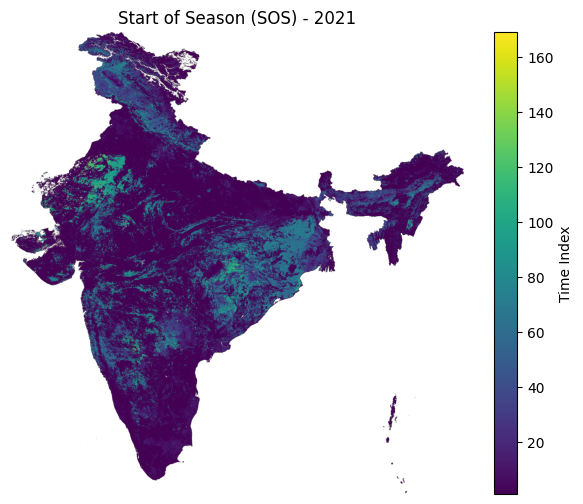

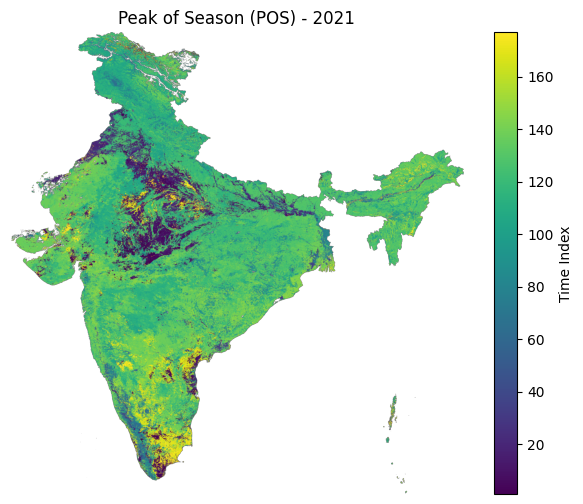

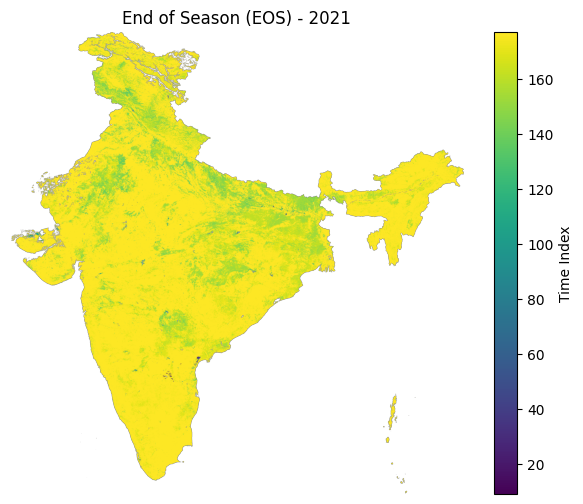

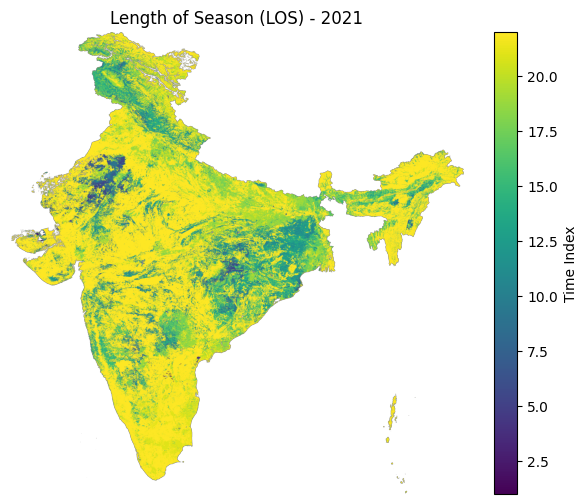

In [ ]:
import matplotlib.pyplot as plt

def plot_raster(file_path, title):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        data[data == -9999] = np.nan  # Mask no-data
        plt.figure(figsize=(8, 6))
        plt.imshow(data, cmap='viridis')
        plt.colorbar(label="Time Index")
        plt.title(title)
        plt.axis('off')
        plt.show()

# Example visualizations
plot_raster("SOS_2021.tif", "Start of Season (SOS) - 2021")
plot_raster("POS_2021.tif", "Peak of Season (POS) - 2021")
plot_raster("EOS_2021.tif", "End of Season (EOS) - 2021")
plot_raster("LOS_2021.tif", "Length of Season (LOS) - 2021")


In [ ]:
!pip install rasterio
!pip install tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.8 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib


In [ ]:
import gdown

# Use the shared link ID
file_id = "15k4SuRKM9hvwWRGvJPa0ZMK5xlr8rcVE"
output_path = "/content/MOD13A1_NIRv_Stack_2021_to_June2022.tif"

# Download the file
gdown.download(id=file_id, output=output_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=15k4SuRKM9hvwWRGvJPa0ZMK5xlr8rcVE
From (redirected): https://drive.google.com/uc?id=15k4SuRKM9hvwWRGvJPa0ZMK5xlr8rcVE&confirm=t&uuid=11b3eeed-3922-43f7-937c-9b693a06066a
To: /content/MOD13A1_NIRv_Stack_2021_to_June2022.tif
100%|██████████| 1.21G/1.21G [00:11<00:00, 101MB/s]


'/content/MOD13A1_NIRv_Stack_2021_to_June2022.tif'

In [ ]:
# STEP 1: Install required packages
!pip install -q rasterio gdown tqdm scipy

# STEP 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 3: Download GeoTIFF from shared Google Drive link
import gdown

file_id = "15k4SuRKM9hvwWRGvJPa0ZMK5xlr8rcVE"
output_path = "/content/MOD13A1_NIRv_Stack_2021_to_June2022.tif"

gdown.download(id=file_id, output=output_path, quiet=False)

# STEP 4: Import required libraries
import numpy as np
import rasterio
from scipy.signal import savgol_filter
from datetime import datetime, timedelta
from tqdm import tqdm
import os

# STEP 5: Define input/output paths
input_path = output_path
output_dir = "/content"

# Define 16-day interval dates from Jan 1, 2021 to June 30, 2022 (approx 34 time steps)
start_date = datetime(2021, 1, 1)
dates = [start_date + timedelta(days=16 * i) for i in range(34)]
julian_days = np.array([int(d.strftime("%j")) for d in dates])

# STEP 6: Define phenology extraction function
def extract_phenology(pixel_ts):
    if np.all(np.isnan(pixel_ts)):
        return [np.nan] * 4

    try:
        smoothed = savgol_filter(pixel_ts, window_length=5, polyorder=3, mode='interp')
    except:
        return [np.nan] * 4

    amp = np.nanmax(smoothed) - np.nanmin(smoothed)
    if amp < 0.02:
        return [np.nan] * 4

    min_val = np.nanmin(smoothed)
    max_val = np.nanmax(smoothed)
    sos_thresh = min_val + 0.2 * amp
    eos_thresh = min_val + 0.3 * amp

    above_thresh = np.where(smoothed > sos_thresh)[0]
    if len(above_thresh) < 2:
        return [np.nan] * 4

    SOS_idx = above_thresh[0]
    POS_idx = np.nanargmax(smoothed)

    # EOS is first index after POS where value drops below EOS threshold
    EOS_idx = next((i for i in range(POS_idx, len(smoothed)) if smoothed[i] < eos_thresh), above_thresh[-1])

    LOS = EOS_idx - SOS_idx if EOS_idx >= SOS_idx else (len(smoothed) - SOS_idx + EOS_idx)

    return [
        julian_days[SOS_idx],
        julian_days[POS_idx],
        julian_days[EOS_idx],
        LOS
    ]

# STEP 7: Load raster stack and initialize output arrays
with rasterio.open(input_path) as src:
    profile = src.profile
    stack = src.read()
    height, width = profile['height'], profile['width']
    profile.update(count=1, dtype='float32', nodata=np.nan)

SOS = np.full((height, width), np.nan, dtype='float32')
POS = np.full((height, width), np.nan, dtype='float32')
EOS = np.full((height, width), np.nan, dtype='float32')
LOS = np.full((height, width), np.nan, dtype='float32')

# STEP 8: Process pixel-wise phenology
for i in tqdm(range(height), desc="Extracting Phenology"):
    for j in range(width):
        pixel_ts = stack[:, i, j]
        if np.all(np.isnan(pixel_ts)):
            continue
        sos, pos, eos, los = extract_phenology(pixel_ts)
        SOS[i, j] = sos
        POS[i, j] = pos
        EOS[i, j] = eos
        LOS[i, j] = los

# STEP 9: Save outputs
output_files = {
    "SOS_2021_2022.tif": SOS,
    "POS_2021_2022.tif": POS,
    "EOS_2021_2022.tif": EOS,
    "LOS_2021_2022.tif": LOS
}

for fname, data in output_files.items():
    out_path = os.path.join(output_dir, fname)
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(data, 1)

print("✅ Phenological metrics extracted and saved as GeoTIFFs.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From (original): https://drive.google.com/uc?id=15k4SuRKM9hvwWRGvJPa0ZMK5xlr8rcVE
From (redirected): https://drive.google.com/uc?id=15k4SuRKM9hvwWRGvJPa0ZMK5xlr8rcVE&confirm=t&uuid=8ef9379e-d03a-4af7-b89e-27b968317b96
To: /content/MOD13A1_NIRv_Stack_2021_to_June2022.tif
100%|██████████| 1.21G/1.21G [00:11<00:00, 109MB/s] 
Extracting Phenology:   5%|▌         | 174/3326 [00:32<14:59,  3.51it/s]<ipython-input-11-f76b0ae0033d>:43: RuntimeWarning: All-NaN slice encountered
  amp = np.nanmax(smoothed) - np.nanmin(smoothed)
<ipython-input-11-f76b0ae0033d>:47: RuntimeWarning: All-NaN slice encountered
  min_val = np.nanmin(smoothed)
<ipython-input-11-f76b0ae0033d>:48: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(smoothed)
Extracting Phenology: 100%|██████████| 3326/3326 [26:32<00:00,  2.09it/s]


✅ Phenological metrics extracted and saved as GeoTIFFs.
